In [1]:
from numpy.random import seed
seed(22) #6,11,22
#from tensorflow import set_random_seed
#set_random_seed(25) 

import numpy as np
import pandas as pd

PARTICIPANT_ID='Sub01'

df_csv=pd.read_csv('data/Provo_Corpus-Eyetracking_Data(sub1-10).csv',usecols=['Participant_ID','Text_ID','Word_Cleaned','IA_SKIP'])
df_csv=df_csv[(df_csv['Participant_ID']==PARTICIPANT_ID)]
df_csv=df_csv.drop(['Participant_ID'],axis=1) #删除列，轴为1
df_csv=df_csv.fillna(' ')
list_data=[]
for j in range(1,56): #句子1-55
    df=df_csv[(df_csv['Text_ID']==j)][['Word_Cleaned','IA_SKIP']] #只保留'Word_Cleaned','IA_SKIP'两列
    mylist = np.array(df).tolist()
    list_data.append(mylist)

texts=[[j[0] for j in i]for i in list_data]
labels=[[j[1] for j in i]for i in list_data]
#print(labels)

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
MAX_NB_WORDS = 2000 #字典大小
MAX_SEQUENCE_LENGTH = max(len(s) for s in texts)
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
MAX_NB_WORDS = len(word_index)+1 #重新修正字典大小
#print(word_index)
x = pad_sequences(sequences, MAX_SEQUENCE_LENGTH)  # left padding
#print(x)
y = pad_sequences(labels, MAX_SEQUENCE_LENGTH, value=0)  # left padding
y = np.expand_dims(y, 2)
#print(y)
train_x=x[0:45]
train_y=y[0:45]
test_x=x[45:]
test_y=y[45:]

Using TensorFlow backend.


In [3]:
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM,Dense, Conv1D, GlobalMaxPooling1D,TimeDistributed
from keras_contrib.layers import CRF

EMBEDDING_DIM = 200
BiRNN_UNITS = 200

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, mask_zero=True,input_shape=(MAX_SEQUENCE_LENGTH,)))  # Random embedding
#model.add(TimeDistributed(Embedding(MAX_NB_WORDS, EMBEDDING_DIM)))  # Random embedding
#model.add(TimeDistributed(Conv1D(128, 5, activation='relu')))
#model.add(TimeDistributed(GlobalMaxPooling1D()))
model.add(Bidirectional(LSTM(BiRNN_UNITS // 2, return_sequences=True)))

crf = CRF(2, sparse_target=True)
model.add(crf)
model.summary()
model.compile(optimizer='adam', loss=crf.loss_function, metrics=[crf.accuracy])


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 60, 200)           238600    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 60, 200)           240800    
_________________________________________________________________
crf_1 (CRF)                  (None, 60, 2)             410       
Total params: 479,810
Trainable params: 479,810
Non-trainable params: 0
_________________________________________________________________


C:\Users\Administrator\Anaconda3\envs\tensorflow\lib\site-packages\keras_contrib-2.0.8-py3.7.egg\keras_contrib\layers\crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
C:\Users\Administrator\Anaconda3\envs\tensorflow\lib\site-packages\keras_contrib-2.0.8-py3.7.egg\keras_contrib\layers\crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy


In [4]:
EPOCHS = 10

# train model
train_history=model.fit(train_x, train_y,batch_size=4,epochs=EPOCHS, validation_data=[test_x, test_y])
model.save('model/crf.h5')

Instructions for updating:
Use tf.cast instead.
Train on 45 samples, validate on 10 samples
Epoch 1/10
45/45 [==============================] - 5s 105ms/step - loss: 0.9849 - crf_viterbi_accuracy: 0.6771 - val_loss: 0.9346 - val_crf_viterbi_accuracy: 0.5826
Epoch 2/10
45/45 [==============================] - 1s 29ms/step - loss: 0.9487 - crf_viterbi_accuracy: 0.6779 - val_loss: 0.9341 - val_crf_viterbi_accuracy: 0.5826
Epoch 3/10
45/45 [==============================] - 1s 28ms/step - loss: 0.9200 - crf_viterbi_accuracy: 0.6812 - val_loss: 0.9046 - val_crf_viterbi_accuracy: 0.5850
Epoch 4/10
45/45 [==============================] - 1s 29ms/step - loss: 0.8746 - crf_viterbi_accuracy: 0.6901 - val_loss: 0.8876 - val_crf_viterbi_accuracy: 0.5846
Epoch 5/10
45/45 [==============================] - 1s 28ms/step - loss: 0.8012 - crf_viterbi_accuracy: 0.7090 - val_loss: 0.8698 - val_crf_viterbi_accuracy: 0.6074
Epoch 6/10
45/45 [==============================] - 1s 28ms/step - loss: 0.7001 - 

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline 
%config InlineBackend.figure_format = 'svg'
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel('accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'])
    plt.show()


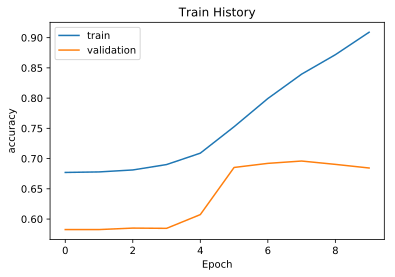

In [6]:
show_train_history(train_history,'crf_viterbi_accuracy','val_crf_viterbi_accuracy')

In [7]:
prediction=model.predict_classes(test_x)

In [8]:
s1=prediction[0]

In [9]:
s2=np.squeeze(test_y[0]) #squeeze 函数：从数组的形状中删除单维度条目，即把shape中为1的维度去掉

(<Figure size 432x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000000015340860>,
       dtype=object))

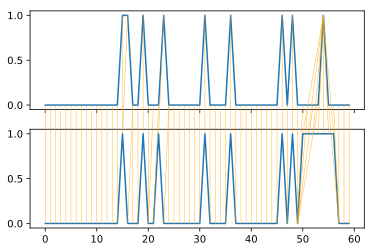

In [10]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import numpy as np
#s1 = np.array([0., 0, 1, 2, 1, 0, 1, 0, 0, 2, 1, 0, 0])
#s2 = np.array([0., 1, 2, 3, 1, 0, 0, 0, 2, 1, 0, 0, 0])
path = dtw.warping_path(s1, s2)

dtwvis.plot_warping(s1, s2, path, filename="Fig6.eps")
dtwvis.plot_warping(s1, s2, path, filename="Fig6.png")
dtwvis.plot_warping(s1, s2, path)

(<Figure size 720x720 with 4 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1c27f9e8>])

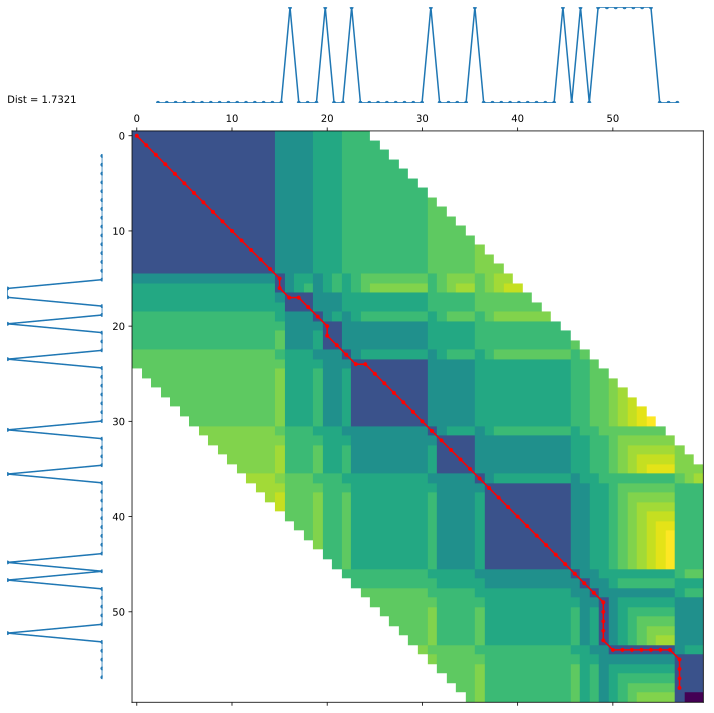

In [11]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import numpy as np

d, paths = dtw.warping_paths(s1, s2, window=25, psi=2)
best_path = dtw.best_path(paths)
dtwvis.plot_warpingpaths(s1, s2, paths, best_path, filename="Fig7.eps")
dtwvis.plot_warpingpaths(s1, s2, paths, best_path, filename="Fig7.png")
dtwvis.plot_warpingpaths(s1, s2, paths, best_path)

In [12]:
from dtaidistance import dtw
s1 = [0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1]
s2 = [1,0,1,0,1,0,1,0,1,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1]
distance = dtw.distance(s1, s2)
print(distance)

1.0
